In [17]:
#!unzip yoga_test.zip -d '/content/gdrive/My Drive/'
#!unzip yoga_train.zip -d '/content/gdrive/My Drive/'

#!pip install "torch==1.4" "torchvision==0.5.0"

In [18]:
import torch
import os
import torchvision
import tarfile
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F


In [2]:
project_name='Course-Project-YogaPose1-classifier'
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing 

In [20]:

data_dir = '../input/yoga-dataset/yoga_dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['valid', 'train', 'export.pkl']
['downwarddog', 'plank', 'childs', 'bridge', 'tree', 'mountain', 'warrior2', 'warrior1', 'seatedforwardbend', 'trianglepose']


In [124]:
files = os.listdir(data_dir + "/train/" + classes[9])
file_count = len(files)
print('No. of training examples for Triangle Pose:' + str(file_count))

No. of training examples for Triangle Pose:65


In [125]:
downwarddog_files = os.listdir(data_dir + "/train/downwarddog")
print('No. of training examples for Downward Dog:', len(downwarddog_files))
print(downwarddog_files[1:5])

No. of training examples for Downward Dog: 90
['File25.jpg', 'File44.jpg', 'File63.jpg', 'File10.jpg']



Transformations
*    Since images are of different sizes, we reseize it to a standard 256x256
*   Random cropping of image
*   Flipping doesn't make sense here because a flipped pose is not necessarily the same
*   We also normalize with a set of random mean and variances incase of using a pre-trained model to perform transfer learning.





In [23]:
stats = ((0.7801192402839661, 0.7550891041755676, 0.7373213768005371), (0.32864445447921753, 0.3389450013637543, 0.35464248061180115))
transformations = T.Compose([
    T.Resize([256, 256]),
    T.ToTensor(),
    T.Normalize(*stats, inplace=True)
    
])

dataset = ImageFolder(data_dir+'/train', transform=transformations)


In [24]:
dataset[0]

(tensor([[[0.8392, 0.8392, 0.8431,  ..., 0.7922, 0.7725, 0.7647],
          [0.8471, 0.8471, 0.8510,  ..., 0.7882, 0.7804, 0.7725],
          [0.8510, 0.8510, 0.8549,  ..., 0.8000, 0.7882, 0.7804],
          ...,
          [0.8157, 0.8471, 0.8706,  ..., 0.6980, 0.6706, 0.7490],
          [0.8353, 0.8431, 0.8549,  ..., 0.7176, 0.6745, 0.7294],
          [0.8471, 0.8510, 0.8549,  ..., 0.7490, 0.7216, 0.7216]],
 
         [[0.7137, 0.7255, 0.7373,  ..., 0.7373, 0.7294, 0.7216],
          [0.7176, 0.7255, 0.7333,  ..., 0.7373, 0.7255, 0.7176],
          [0.7176, 0.7255, 0.7294,  ..., 0.7333, 0.7333, 0.7294],
          ...,
          [0.6706, 0.6863, 0.7255,  ..., 0.6314, 0.6039, 0.6706],
          [0.6902, 0.6902, 0.7098,  ..., 0.6353, 0.6078, 0.6627],
          [0.7059, 0.7137, 0.7098,  ..., 0.6549, 0.6431, 0.6471]],
 
         [[0.4627, 0.4627, 0.4824,  ..., 0.4980, 0.5059, 0.4980],
          [0.4510, 0.4431, 0.4824,  ..., 0.5176, 0.5137, 0.5176],
          [0.4549, 0.4588, 0.4784,  ...,

In [126]:
len(dataset)

730

There are 730 images in our Training dataset

In [25]:
print(dataset.classes)

['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


There are 10 different poses each class containing varying number of images in each.






Label:  bridge (0)


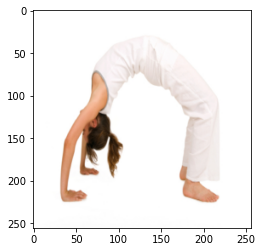

In [26]:
import matplotlib.pyplot as plt

def print_sample(img, label=0):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

print_sample(*dataset[10])

Label:  warrior2 (9)


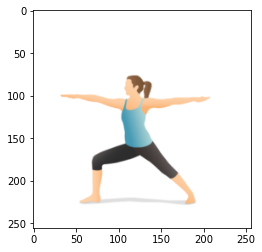

In [27]:
print_sample(*dataset[720])

In [29]:
from torch.utils.data.dataloader import DataLoader

In [30]:
random_seed = 42
torch.manual_seed(random_seed);

In [31]:
val_size = 100
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True )
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [32]:
from fastai.vision import *
from fastai.widgets import *

In [33]:
data_bunch = ImageDataBunch.from_folder(
    # Data director
    Path(data_dir), train='train', valid='valid',
    # Reserve 5 percent of our images for our validation set
    valid_pct=0.05,
    # Transforms to apply to the image to create variations on our training image
    ds_tfms=get_transforms(max_zoom=1.0), 
    # Dimension of image to process
    size=299,
    # Num workers to use
    num_workers=2
).normalize(
	# Use imagenet stats to normalize (to match what was pre-trained with)
	imagenet_stats
)

### One time execution
Calculating mean and variance for transform normalization


In [34]:
'''mean = 0.0
for images, _ in train_dl:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(train_dl.dataset)

var = 0.0
for images, _ in train_dl:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(train_dl.dataset)*224*224))'''

'mean = 0.0\nfor images, _ in train_dl:\n    batch_samples = images.size(0) \n    images = images.view(batch_samples, images.size(1), -1)\n    mean += images.mean(2).sum(0)\nmean = mean / len(train_dl.dataset)\n\nvar = 0.0\nfor images, _ in train_dl:\n    batch_samples = images.size(0)\n    images = images.view(batch_samples, images.size(1), -1)\n    var += ((images - mean.unsqueeze(1))**2).sum([0,2])\nstd = torch.sqrt(var / (len(train_dl.dataset)*224*224))'

In [35]:
#mean.tolist(), std.tolist()

## A single batch of data

'def imshow_grid(images, shape=[2, 8]):\n    """Plot images in a grid of a given shape."""\n    fig = plt.figure(1)\n    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)\n\n    size = shape[0] * shape[1]\n    for i in range(size):\n        grid[i].axis(\'off\')\n        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.\n\n    plt.show()'

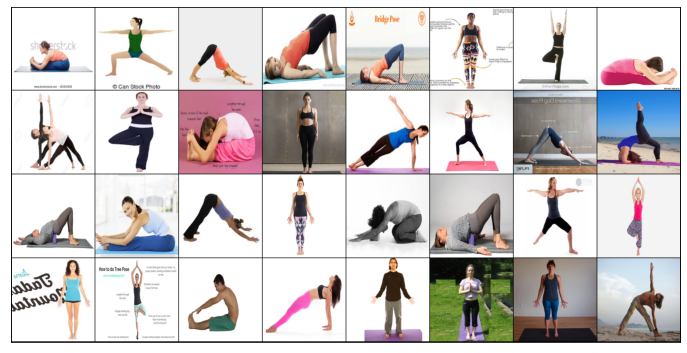

In [36]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

'''def imshow_grid(images, shape=[2, 8]):
    """Plot images in a grid of a given shape."""
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    plt.show()'''
#imshow_grid(train_dl)

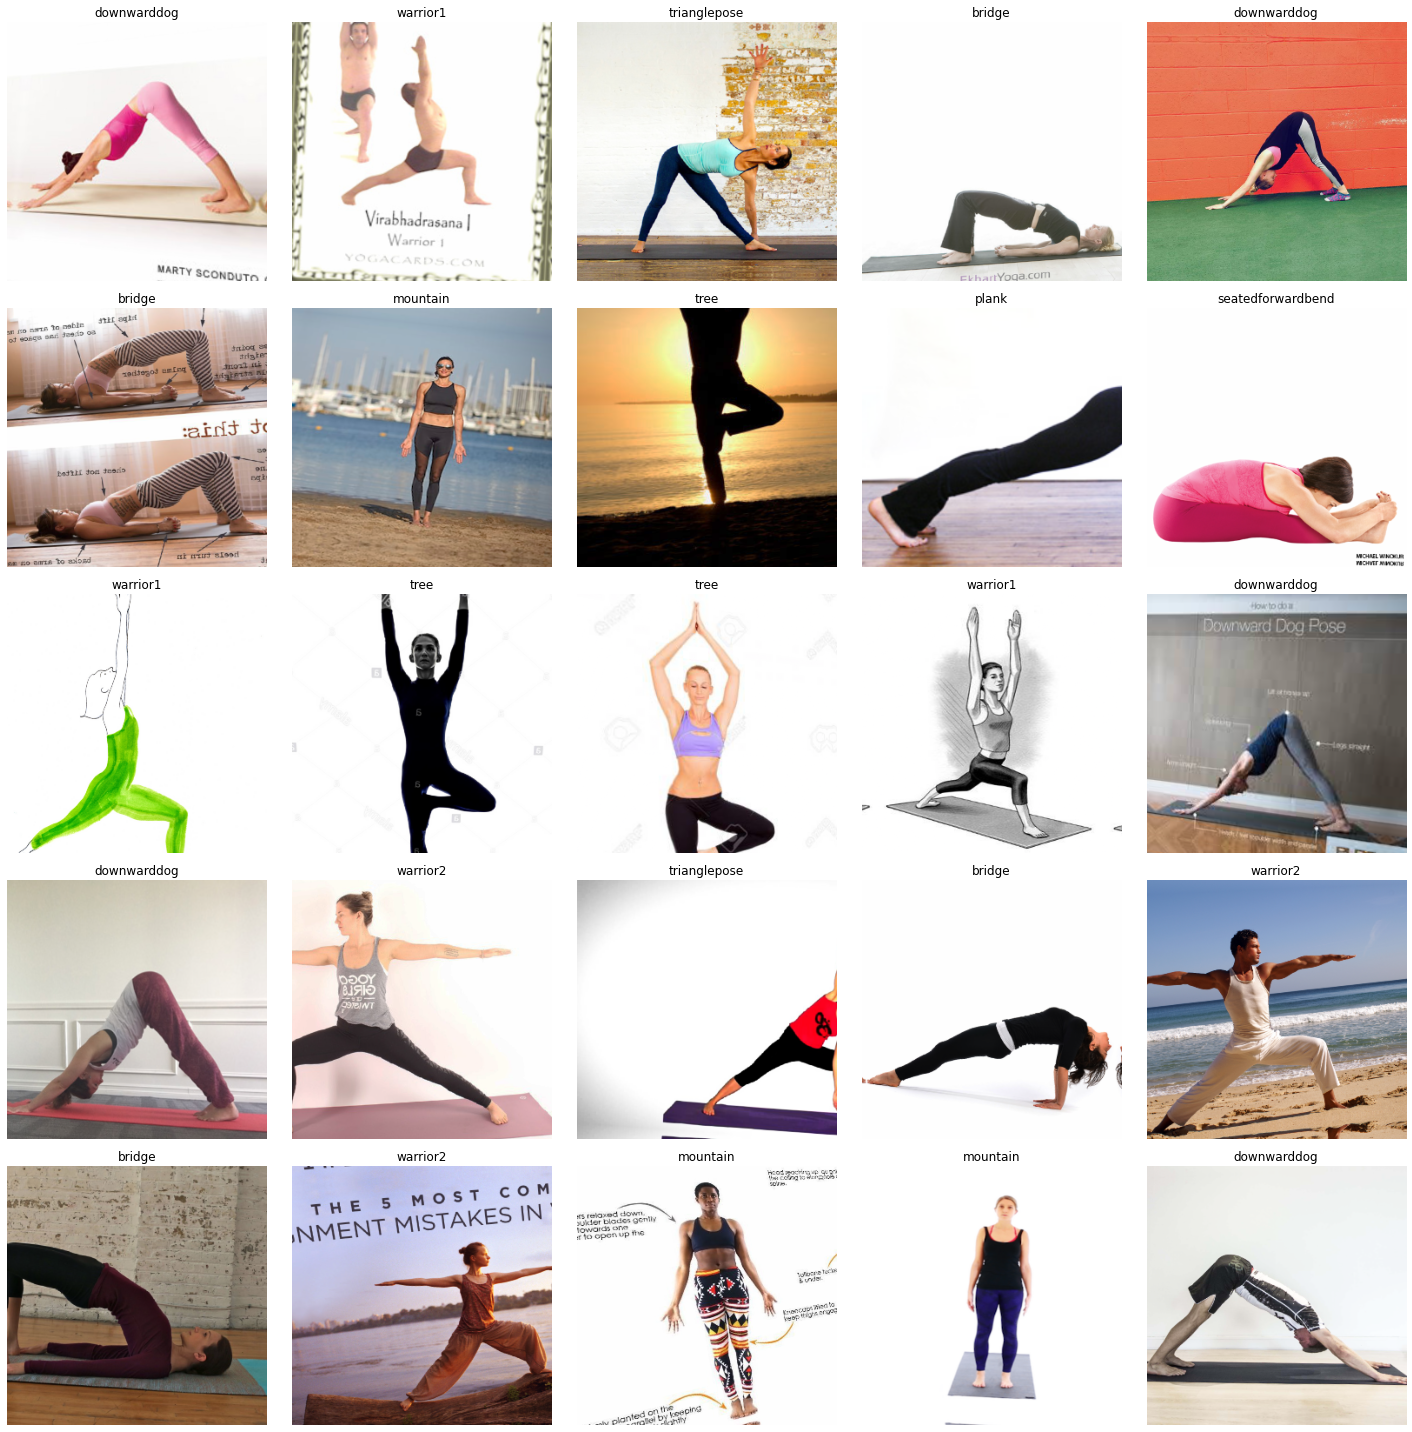

In [37]:
data_bunch.show_batch()

## Model definition

In [38]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 256, 256])
out.shape: torch.Size([32, 8, 128, 128])


In [39]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Simple CNN model 

In [40]:
class YogaSimpleCnn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(256*256*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        #xb = xb.view(xb.size(0), -1)
        return self.network(xb)

### Model 2 - Resnet 9 

In [41]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.LeakyReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.conv5 = conv_block(512, 1024, pool=True)
        self.conv6 = conv_block(1024, 2048, pool=True)
        self.res3 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))

        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(2048*2*2, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

## Facilitation of GPU use and setting Torch - Cuda compatibility

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [43]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model1 = to_device(YogaSimpleCnn(), device)




### Model 3 - Fast AI - Squeezenet 

In [44]:
learner = cnn_learner(data_bunch, models.squeezenet1_1, pretrained=True, metrics=accuracy)	


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


In [45]:
"""for images, labels in train_dl:
    print('images.shape:', images.shape)
    #images = images.view(32, 3, 256, 256)
    #images = images.unsqueeze(dim = 0)
    out = model1(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break"""

"for images, labels in train_dl:\n    print('images.shape:', images.shape)\n    #images = images.view(32, 3, 256, 256)\n    #images = images.unsqueeze(dim = 0)\n    out = model1(images)\n    print('out.shape:', out.shape)\n    print('out[0]:', out[0])\n    break"

### For testing if data loads and model produces the expected output on a batch of training data

In [46]:
'''for images, labels in train_dl:
    print('images.shape:', images.shape)
    #images = images.view(32, 3, 256, 256)
    #images = images.unsqueeze(dim = 0)
    out = model2(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break'''

"for images, labels in train_dl:\n    print('images.shape:', images.shape)\n    #images = images.view(32, 3, 256, 256)\n    #images = images.unsqueeze(dim = 0)\n    out = model2(images)\n    print('out.shape:', out.shape)\n    print('out[0]:', out[0])\n    break"

## Model Training 

In [47]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [48]:
history1 = [evaluate(model1, val_dl)]
history1

[{'val_loss': 2.306926727294922, 'val_acc': 0.046875}]

In [49]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [50]:
history1 += fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3006, val_loss: 2.2437, val_acc: 0.2188
Epoch [1], train_loss: 2.2471, val_loss: 2.2354, val_acc: 0.2188
Epoch [2], train_loss: 2.2466, val_loss: 2.2311, val_acc: 0.2188
Epoch [3], train_loss: 2.1848, val_loss: 2.1830, val_acc: 0.2422
Epoch [4], train_loss: 1.9773, val_loss: 1.9554, val_acc: 0.2891
Epoch [5], train_loss: 1.7806, val_loss: 1.9577, val_acc: 0.2734
Epoch [6], train_loss: 1.6276, val_loss: 1.8155, val_acc: 0.3984
Epoch [7], train_loss: 1.4434, val_loss: 1.9336, val_acc: 0.3594
Epoch [8], train_loss: 1.0821, val_loss: 1.8337, val_acc: 0.3828
Epoch [9], train_loss: 0.8033, val_loss: 2.0345, val_acc: 0.5312
Epoch [10], train_loss: 0.4904, val_loss: 2.0211, val_acc: 0.5000
Epoch [11], train_loss: 0.3149, val_loss: 2.0646, val_acc: 0.5078
Epoch [12], train_loss: 0.3186, val_loss: 1.8702, val_acc: 0.5781
Epoch [13], train_loss: 0.1553, val_loss: 2.4629, val_acc: 0.5625
Epoch [14], train_loss: 0.1312, val_loss: 2.6808, val_acc: 0.4766
Epoch [15], train_lo

In [52]:
model2 = to_device(ResNet9(3, 10), device)
model2

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, m

In [53]:
history2 = [evaluate(model2, val_dl)]
history2

[{'val_loss': 2.303985834121704, 'val_acc': 0.046875}]

In [54]:
epochs = 35
max_lr = 1e-5
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [56]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 2.8968, val_loss: 2.4023, val_acc: 0.0938
Epoch [1], train_loss: 2.0881, val_loss: 2.3887, val_acc: 0.0859
Epoch [2], train_loss: 1.5678, val_loss: 1.8630, val_acc: 0.3828
Epoch [3], train_loss: 1.0583, val_loss: 1.5265, val_acc: 0.5312
Epoch [4], train_loss: 0.6711, val_loss: 1.3686, val_acc: 0.6328
Epoch [5], train_loss: 0.3796, val_loss: 1.2805, val_acc: 0.6016
Epoch [6], train_loss: 0.2162, val_loss: 1.3084, val_acc: 0.5703
Epoch [7], train_loss: 0.1659, val_loss: 1.2607, val_acc: 0.6406
Epoch [8], train_loss: 0.1252, val_loss: 1.2942, val_acc: 0.5859
Epoch [9], train_loss: 0.0884, val_loss: 1.2323, val_acc: 0.6094
Epoch [10], train_loss: 0.0597, val_loss: 1.2946, val_acc: 0.5938
Epoch [11], train_loss: 0.0589, val_loss: 1.2070, val_acc: 0.6094
Epoch [12], train_loss: 0.0492, val_loss: 1.2525, val_acc: 0.6172
Epoch [13], train_loss: 0.0597, val_loss: 1.2491, val_acc: 0.6250
Epoch [14], train_loss: 0.0477, val_loss: 1.2319, val_acc: 0.6406
Epoch [15], train_lo

In [57]:
import warnings
warnings.filterwarnings("ignore")

# Start training
learner.fit_one_cycle(10)

# Unfreeze the model
learner.unfreeze()

# Train the entire model some more
learner.fit_one_cycle(10, max_lr=slice(1e-3, 1e-5))

# Reduce the learning rate and train some more
learner.fit_one_cycle(10, max_lr=slice(1e-4, 1e-6))


 ## Prediction and Plotting Losses

In [58]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

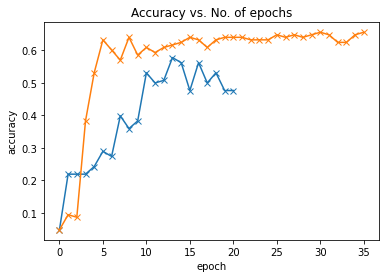

In [62]:
plt.title('Accuracy vs. No. of epochs - Simple CNN');
plot_accuracies(history1)

plt.title('Accuracy vs. No. of epochs - Resnet 9');
plot_accuracies(history2)

In [63]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

Model 1 Loss


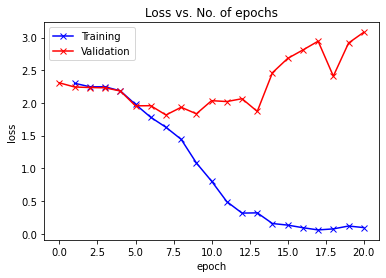

In [66]:
print('Model 1 Loss')
plot_losses(history1)


Model 2 loss


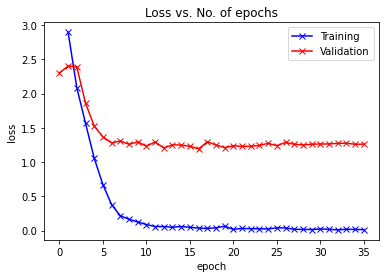

In [65]:
print('Model 2 loss')
plot_losses(history2)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde3058a560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


42 misclassified samples over 42 samples in the validation set.


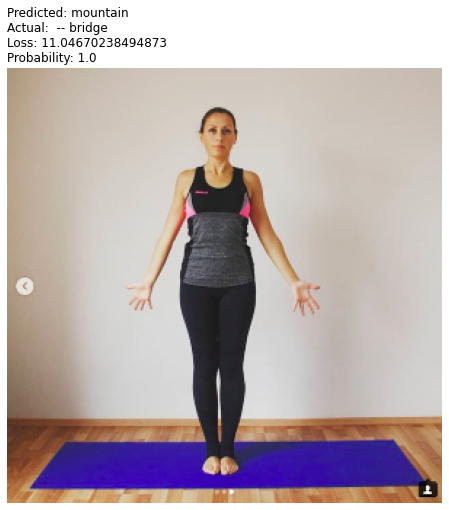

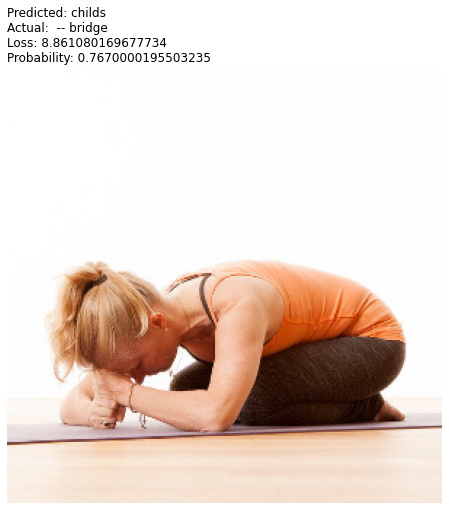

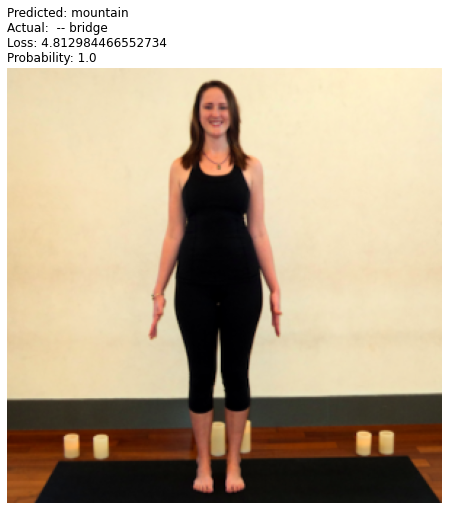

In [67]:
preds,y,losses = learner.get_preds(with_loss=True)
intr = ClassificationInterpretation(learner, preds, y, losses)
intr.plot_multi_top_losses()

In [68]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

### Predict a batch of Test images

In [119]:
test_dataset = ImageFolder(data_dir+'/valid', transform=transformations)

test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size=16, num_workers=2, pin_memory=True), device)

In [120]:
from tqdm.notebook import tqdm
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        break;
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [121]:
test_preds = predict_dl(test_dl, model2)

### Prediction for a single test image 

In [75]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model2(xb)
    prediction = torch.sigmoid(preds.cpu().detach())
    label = [element.item() for element in prediction.flatten()]
    label = label.index(max(label))
    print("Prediction: ", prediction)
    print_sample(image, label)

Prediction:  tensor([[0.4129, 0.3179, 0.8222, 0.8178, 0.0271, 0.3038, 0.7089, 0.8250, 0.8616,
         0.5729]])
Label:  warrior1 (8)


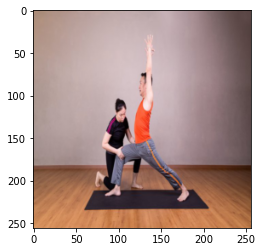

In [76]:

predict_single(test_dataset[100][0])

Correct Labelling example

Prediction:  tensor([[0.7775, 0.4336, 0.8466, 0.8077, 0.3949, 0.4449, 0.2708, 0.8068, 0.4302,
         0.5852]])
Label:  downwarddog (2)


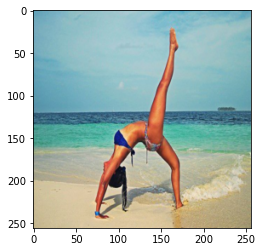

In [77]:
predict_single(test_dataset[10][0])

Misclassified example

Prediction:  tensor([[0.8497, 0.2844, 0.8421, 0.5455, 0.3106, 0.0585, 0.6877, 0.9858, 0.8015,
         0.5225]])
Label:  trianglepose (7)


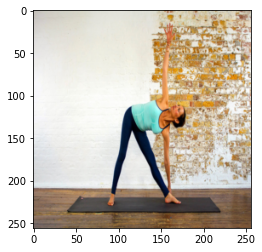

In [84]:
predict_single(test_dataset[92][0])

Correctly classified example

### Fast AI model prediction

In [88]:
import imghdr
import os
from os import walk
#example_image = open_image(Path('/content/g'))
preds = dict(zip(classes, [0]*11))


def img(filename):
  image_type = imghdr.what(filename)
  if image_type:
    return True


# Make a prediction
for folder in os.listdir(data_dir +'/valid'):
  print("for class: " + folder)
  for (dirpath, dirnames, filenames) in walk(data_dir + '/valid/' + folder):
    for filename in filenames:
      fil = data_dir + '/valid/' + folder +'/'+ filename
      if img(fil):
        #print(fil)      
        predicted_class, _, _ = learner.predict(open_image(fil))
        print("predicted val: " + str(predicted_class))

print(preds)

# Export the model
learner.export()

for class: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
predicted val: downwarddog
for class: plank
predicted val: plank
predicted val: trianglepose
predicted val: plank
predicted val: plank
predicted val: trianglepose
predicted val: plank
predicted val: plank
predicted val: plank
predicted val: plank
predicted val: plank
for class: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
predicted val: childs
for class: bridge
predicted val: bridge

OSError: [Errno 30] Read-only file system: '../input/yoga-dataset/yoga_dataset/export.pkl'

here, since our test set is same as the validation set, we get a really accurate classification

warrior1


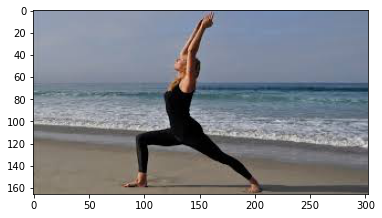

In [93]:
import matplotlib.image as mpimg

image1 = '../input/yoga-example/images.jpg'
def disp_example(image):
    predicted_class, _, _ = learner.predict(open_image(Path(image)))
    print(predicted_class)
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()
    
disp_example(image1)

downwarddog


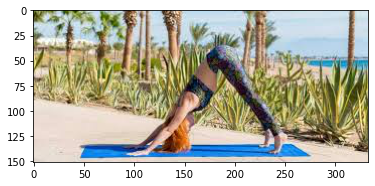

In [94]:
image2 = '../input/yoga-example/images1.jpg'
disp_example(image2)

It's also classifying external examples images well!

Prediction:  tensor([[0.3604, 0.1586, 0.5605, 0.9405, 0.0993, 0.1809, 0.7685, 0.1704, 0.9826,
         0.7702]])
Label:  warrior1 (8)


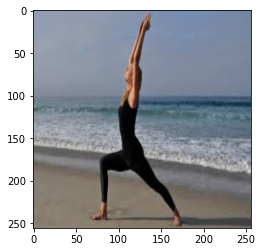

In [110]:
#test_examples =ImageFolder('../input/yoga-example/', transform=transformations)


from PIL import Image 
 
def prnt_ex(im):
    im = Image.open(im)  
  
    im = transformations(im)
    predict_single(im)


prnt_ex(image1)

Prediction:  tensor([[0.8057, 0.4316, 0.6373, 0.9722, 0.4288, 0.4819, 0.6296, 0.5614, 0.2136,
         0.3731]])
Label:  mountain (3)


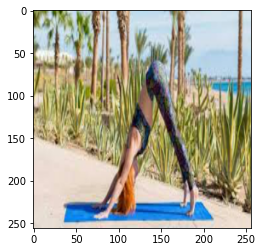

In [111]:
prnt_ex(image2)

The ResNet 9 Model also seems to predict external examples well

In [95]:
'''from google.colab import files
weights_fname = 'resnet-classifier.pth'
torch.save(model.state_dict(), weights_fname)

files.download(weights_fname)'''

"from google.colab import files\nweights_fname = 'resnet-classifier.pth'\ntorch.save(model.state_dict(), weights_fname)\n\nfiles.download(weights_fname)"

In [1]:
!pip install jovian --upgrade --quiet
import jovian

<IPython.core.display.Javascript object>

In [114]:
torch.save(model2.state_dict(), 'yoga-resnet9.pth')
jovian.commit(project=project_name, environment=None, outputs=['yoga-resnet9.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/aharini2008/Course-Project-YogaPose-classifier


<IPython.core.display.Javascript object>

In [118]:
learner.export(file = Path("/kaggle/working/export.pkl"))

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/aharini2008/Course-Project-YogaPose1-classifier


<IPython.core.display.Javascript object>